# Generating Annihilation Rates from Remote Cache of Particle Model
Tim Tyree

In [58]:
from scipy.optimize import minimize

In [35]:
from lib.my_initialization import *
from lib import *
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats
#DONE: hook this routine up to dask
#DONT: hook this routine up to dask_cuda

darkmode=True
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
wjr=recall_powerlaw_fits_to_full_models()
print(*wjr)

fk_pbc lr_pbc fk_ncbc lr_ncbc


In [72]:
# #FK (a_hat short timescale, D_hat long timescale)
# a_hat_FK=7.3923;
D_hat_FK=0.365238#;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15
#msr from the particle model
# npz_dir_FK='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_7.3923_D_0.365238.npz'#csv'
# msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
a_hat_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms

#LR (a_hat short timescale, D_hat long timescale)
a_hat_LR=8.595
D_hat_LR=0.586055#;num_pairs=25;tavg_step=5;tavg1_max=15;tavg2_max=15
#msr from the particle model
# npz_dir_LR='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_8.595_D_0.586055.npz'#.csv'



a_hat_FK = 1.509282#+/-0.178827 cm^2/s, tmax=90
a_hat_LR = 3.535902#+/-0.312245 cm^2/s, tmax=60

# load the resulting table of powerlaw fits and perform interpolation to estimate M,nu

In [40]:
#neighbor-only forces
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_19_all_powerlaw_fits.csv"
#vector-summed forces
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
df=pd.read_csv(input_fn)
# df.tail()

In [47]:
testing=True

#define constant parameters
neighbor=1
# neighbor=0
reflect=0
force_code=2
set_second=0
no_attraction=0
no_repulsion=0
# kappa=100
L=10

#query the DataFrame
query =(df.set_second==set_second)&(df.reflect==reflect)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
# query&=df.r==r
# query&=df.kappa==kappa
# query&=df.D==D
query&=df.L==L
# query&=df.varkappa==varkappa
# query&=df.x0==x0
dg=df[query]

#define parameters to be varied
# input_cols=['r','D','varkappa']#,x0
input_cols=['r','kappa','varkappa','D']#,x0
output_cols=['m','Delta_m','M','Delta_M']#2 minute runtime
output_cols=['m','M']#2.75 minute runtime
#inputs:dg,input_cols,output_col
#output: fitted model

Xall=dg[input_cols].values 
yall=dg[output_cols].values
X=Xall.copy()
y=yall.copy()
m = len(y) # number of training examples
print(f'number of training examples is {m:d}.')

interp = LinearNDInterpolator(X, y)
# interp = CloughTocher2DInterpolator(X, y)
print(f"training complete!")
if testing:
    yhat = interp(X)
    print(f"shape of X {X.shape} --> shape of y=yhat {yhat.shape}")

    rmse=np.sqrt(np.mean((yhat-y)**2))
    print(f"the rmse of simple interpolation is {rmse:.4f}")

number of training examples is 17916.
training complete!
shape of X (17916, 4) --> shape of y=yhat (17916, 2)
the rmse of simple interpolation is 0.0000


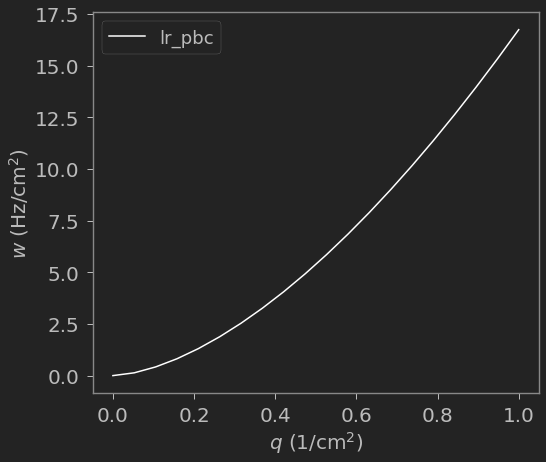

In [112]:
#TODO: dev function from parameter setting to rmse_full
#GOAL: find a best r,kappa pair for a given a,D pair for a given full model
model_name='lr_pbc'
c='C1'
# model_name='fk_pbc'
# c='C0'
#estimate q_values,w_values 

a=a_hat_LR
D=D_hat_LR

if darkmode:
    c='w'

nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full
plt.plot(q_values,w_values,c=c,label=model_name)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=18)
plt.show()

In [113]:
#DONE: compute what_values
#DONE: compute rmse to w_values

In [114]:
def comp_rmse_via_interp(x, *args):
    a,D,q_values,w_values,interp=args
    r,kappa=x
    #interpolate nu and M using interp
    X=np.array([[r,kappa,a,D]])
    yhat = interp(X)
    nu=yhat[0,0]
    M=yhat[0,1]
    # M=yhat[0,2]
    what_values=M*q_values**nu
    rmse_full=np.sqrt(np.mean((what_values-w_values)**2))
    return rmse_full

#TODO: test for a significant speedup by baking in interp
# args=(a,D,q_values,w_values,interp)
# x=(r,kappa)
# def fun(x, *args):
#     a,D,q_values,w_values,interp=args
#     r,kappa=x
#     rmse_full=np.nan
#     return rmse_full

In [115]:
#TODO: return the best r
r=0.1
kappa=1500

print(f"a={a}, D={D}")

a=3.535902, D=0.586055


In [116]:
args=(a,D,q_values,w_values,interp)
x=(r,kappa)
comp_rmse_via_interp(x, *args)

#TODO(option A): use minimize
#TODO(option B): loop over an array of r_values, loop over an array of kappa_values
#TODO(if ^that is prohibitively slow): look for a scipy routine that finds the optimal r,kappa pair faster

1.7467826128496262

In [117]:
# # TODO: find relation between r,kappa and M when a = 0
# # TODO: initialize kappa using M and r=0.1
# x0 = x#(0.1, 500)
# res = minimize(comp_rmse_via_interp,
#                   x0,
#                   args,
#                   method=None,
#                   jac=None,
#                   hess=None,
#                   hessp=None,
#                   bounds=((1e-3, 2), (1e2, 1e4)),
#                   constraints=(),
#                   tol=1e-15,
#                   callback=None,
#                   options=None)
# print(res.x)

In [118]:
# #TODO: add coinstraints of positivity
# cons = ({'type': 'ineq', 'fun': lambda x:  x[0] - 2 * x[1] + 2},
#         {'type': 'ineq', 'fun': lambda x: -x[0] - 2 * x[1] + 6},
#         {'type': 'ineq', 'fun': lambda x: -x[0] + 2 * x[1] + 2})
# And variables must be positive, hence the following bounds:
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = x#(0.1, 500)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='SLSQP', bounds=bnds,tol=1e-3)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
res

 final_simplex: (array([[1.33070330e-01, 6.26495292e+02],
       [1.33070030e-01, 6.26495112e+02],
       [1.33070629e-01, 6.26496249e+02]]), array([0.74815396, 0.74815397, 0.74815397]))
           fun: 0.7481539631900532
       message: 'Optimization terminated successfully.'
          nfev: 98
           nit: 50
        status: 0
       success: True
             x: array([1.33070330e-01, 6.26495292e+02])

Bounds on variables for Nelder-Mead, L-BFGS-B, TNC, SLSQP, Powell, and trust-constr methods.

In [119]:
comp_rmse_via_interp(res.x, *args)
#TODO: try the other available optimization methods
res.x

array([1.33070330e-01, 6.26495292e+02])

In [120]:
#Plot the result over the origninal annihilation rates
X=np.array([[res.x[0],res.x[1],a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=yhat[0,2]
what_values=M*q_values**nu

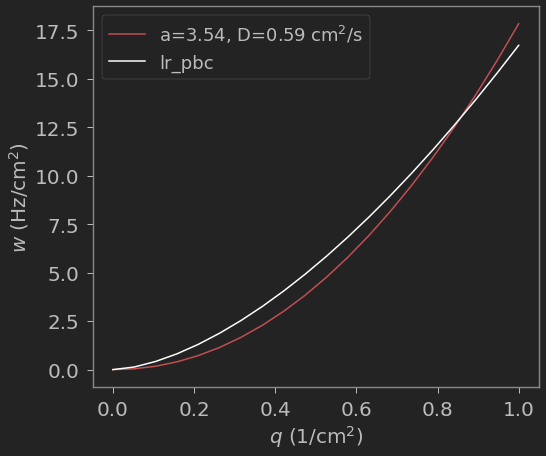

In [121]:
plt.plot(q_values,what_values,c='r',label=f'a={a:.2f}, D={D:.2f}'+r' cm$^2$/s')
plt.plot(q_values,w_values,c=c,label=model_name)
format_plot(ax=plt.gca(),xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w$ (Hz/cm$^2$)')
plt.legend(fontsize=18)
plt.show()